In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook

In [2]:
root_dir = "/mnt/store_dai/datasrc/dchan/gers/change/patches"
fold_nb: int = 0

In [3]:
import sys
sys.path.append("..")

In [4]:
import glob
from pathlib import Path
import csv
from matplotlib import pyplot as plt
import os

import odeon
from odeon.data.data_module import Input
from albumentations.core.transforms_interface import DualTransform
from odeon.models.change.module.change_unet import ChangeUnet
from typing import Optional, Dict, List, Callable
import torch
import mlflow

/home/PVoitot/mambaforge/envs/odeon/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
checkpoint_file = "/mnt/store_dai/pocs/slurm/dchan/mlruns/720467711507771399/4a3a13a1e9b044f193eb95235a70f866/artifacts/model/checkpoints/name=0-epoch-epoch=289-loss-val_bin_iou=0.40/name=0-epoch-epoch=289-loss-val_bin_iou=0.40.ckpt"

model = ChangeUnet.load_from_checkpoint(checkpoint_file)

In [6]:
mean = [0.485, 0.456, 0.406]
std = [0.228, 0.224, 0.225]

def build_params_gers(stage: str, root_dir: str, fold_nb: int, batch_size: int, num_workers: int, transform: Optional[List[Callable]] = None, nb_samples: int = 0, sample_seed = 0) -> Dict:
    fold_dir: str = f'split-{fold_nb}'
    root_fold_dir: str = os.path.join(root_dir, fold_dir)
    dataset: str = os.path.join(root_fold_dir, f'{stage}_split_{fold_nb}.geojson')

    res = {
        'input_fields': {
            "T0": {"name": "T0", "type": "raster", "dtype": "uint8", "band_indices": [1, 2, 3], "mean": mean, "std": std},
            "T1": {"name": "T1", "type": "raster", "dtype": "uint8", "band_indices": [1, 2, 3], "mean": mean, "std": std},
            "mask": {"name": "change", "type": "mask"},
        },
        'dataloader_options' : {"batch_size": batch_size, "num_workers": num_workers},
        'input_file': dataset,
        'root_dir': root_dir,
        'nb_samples': nb_samples,
        'sample_seed': sample_seed
    }

    if transform:
        res["transform"] = transform
    return res


In [7]:
nb_samples = 10
batch_size = 10
num_workers = 8
transform = None
seed = 0

fit_params = build_params_gers("train", root_dir, fold_nb, batch_size, num_workers, transform, nb_samples, seed)
val_params = build_params_gers("val", root_dir, fold_nb, batch_size, num_workers, None, nb_samples, seed)
test_params = build_params_gers("test", root_dir, fold_nb, batch_size, num_workers, None, nb_samples, seed)


In [8]:
input = Input(
        fit_params=fit_params,
        validate_params=val_params,
        test_params=test_params
    )

In [9]:
input.prepare_data()
input.setup(stage="validate")

Sampled                                                                             id  \
127  455836.80000000005-6287841.600000005-455939.20000000007-6287944.000000006   
48                             441398.4-6282312.0-441500.80000000005-6282414.4   
487                    457526.4-6319278.4-457628.80000000005-6319380.800000001   
409                    448771.2000000002-6316872.0-448873.6000000002-6316974.4   
225   456553.6000000002-6287124.800000003-456656.00000000023-6287227.200000003   
339                                      456656.0-6302280.0-456758.4-6302382.4   
239                  503196.80000000005-6287688.0-503299.20000000007-6287790.4   
523                      493776.0-6323732.800000003-493878.4-6323835.200000003   
593                            465718.4-6294600.0-465820.80000000005-6294702.4   
412   448771.2000000002-6317179.200000001-448873.6000000002-6317281.6000000015   

       id_zone  \
127   NU_S1_73   
48    UC_S1_56   
487  VC_S1_208   
409  VC_S1_197   

In [10]:
def image_line(list_images, col_titles):
    # Create a figure to contain the plot.
    figure = plt.figure(figsize=(2 * len(col_titles), 3))
    for i, title in enumerate(col_titles):
        # Start next subplot.
        plt.subplot(1, len(col_titles), i + 1, title=title)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = list_images[i].detach().cpu().permute(1, 2, 0).numpy()
        plt.imshow(img, interpolation='nearest', vmin=0, vmax=255)
        plt.tight_layout()

    return figure

def image_lines(rows, row_titles, col_titles):
        """Return a 5x5 grid of the MNIST images as a matplotlib figure."""
        # Create a figure to contain the plot.
        # titles = ['T0', 'T1', 'GroundTruth', 'Prediction']
        figure = plt.figure(figsize=(2 * len(col_titles), 2 * len(row_titles)))
        gs = figure.add_gridspec(len(row_titles), len(col_titles)) #, hspace=0, wspace=0)
        axes = gs.subplots(sharex='col', sharey='row')
        plt.yticks([])
        plt.grid(False)

        for ax, col in zip(axes[0], col_titles):
            ax.set_title(col)
        for ax, row in zip(axes[:,0], row_titles):
            ax.set_ylabel(row, rotation=0, size='large')
        for i, row in enumerate(rows):
            for j, img in enumerate(row):
                img = img.detach().cpu().permute(1, 2, 0).numpy()
                axes[i, j].imshow(img, interpolation='nearest')
        plt.tight_layout()

        return figure

def denormalize_img_as_tensor(image: torch.Tensor, mean, std):
    """
    Args:
        tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
    Returns:
        Tensor: Normalized image.
    """
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)

    return image

/tmp/ipykernel_196100/3166219043.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


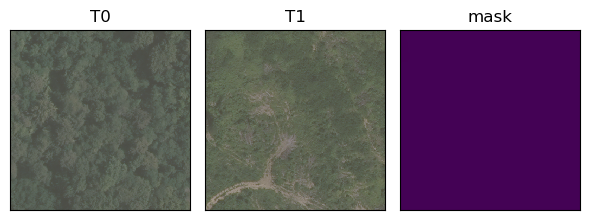

In [33]:
v = input.validate.dataset[0]
T0 = denormalize_img_as_tensor(v['T0'], mean, std)
T1 = denormalize_img_as_tensor(v['T1'], mean, std)

_ = image_line([T0, T1, v['mask']], ['T0', 'T1', 'mask'])

In [122]:
import os
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from torchvision.transforms import ToPILImage, Lambda
import numpy as np

def process_inputs(input: Input, stage: str):
    step = 0
    
    input.prepare_data()
    input.setup(stage=stage)
    
    if stage == "fit":
        data = input.fit
    elif stage == "validate":
        data = input.validate
    elif stage == "test":
        data = input.test
        
    os.makedirs(f"gers/{stage}/T0",exist_ok=True)
    os.makedirs(f"gers/{stage}/T1",exist_ok=True)
    os.makedirs(f"gers/{stage}/change",exist_ok=True)
    os.makedirs(f"gers/{stage}/preds",exist_ok=True)
    os.makedirs(f"gers/{stage}/logits",exist_ok=True)

    for v in tqdm(data.dataset):
    #     if step > 5:
    #         break
        df = data.dataframe.iloc[step]
        with torch.no_grad():
            model.eval()
            T0 = v['T0'].unsqueeze(dim=0)
            T1 = v['T1'].unsqueeze(dim=0)
            y = v['mask'].unsqueeze(dim=0)
            name = df["T0"].split("/")[1][:-5]
    #         print("patch", name, df)
            y_pred = model(T0, T1)
            if (y_pred.shape[1] > 1):
                y_hard_pred = torch.argmax(y_pred, dim=1, keepdim=True)
            else:
                y_pred = torch.sigmoid(y_pred) # WARNING: how to know activation in general?
                y_hard_pred = (y_pred > 0.5).float()   
            viz_batch = (T0, T1, y, y_pred)

            T0 = denormalize_img_as_tensor(T0, np.array(mean), np.array(std))
            T1 = denormalize_img_as_tensor(T1, np.array(mean), np.array(std))

#             color_mapping = Lambda(lambda x: (255, 255, 0) if x[0, 0] == 1 else (0, 0, 0))
#             colored_image = torch.zeros((*binary_tensor.shape, 3), dtype=torch.uint8)

            # Set yellow color for values equal to 1
#             colored_image[binary_tensor == 1] = torch.tensor([255, 255, 0], dtype=torch.uint8)


            transform = T.ToPILImage()

            # convert the tensor to PIL image using above transform

            T0_file = f'gers/{stage}/T0/{name}.png'
            T0_img = transform(T0.squeeze())
            T0_img.save(T0_file)
            
            T1_file = f'gers/{stage}/T1/{name}.png'
            T1_img = transform(T1.squeeze())
            T1_img.save(T1_file)
            
            y_pred_file = f'gers/{stage}/logits/{name}.png'
            y_pred = y_pred.squeeze().numpy()
            y_pred_img = np.zeros((*y_pred.shape, 3), dtype=np.uint8)
            y_pred_img[:, :, 0] = y_pred[:, :] * 255
            y_pred_img[:, :, 1] = y_pred[:, :] * 255
            y_pred_img = transform(y_pred_img)
            y_pred_img.save(y_pred_file)
            
            y_file = f'gers/{stage}/change/{name}.png'
            y = y.squeeze().numpy()
            y_img = np.zeros((*y.shape, 3), dtype=np.uint8)
            y_img[y == 1] = [255, 255, 0]
            y_img = transform(y_img)
            y_img.save(y_file)


            y_hard_pred_file = f'gers/{stage}/preds/{name}.png'
            y_hard_pred = y_hard_pred.squeeze().numpy()
            y_hard_pred_img = np.zeros((*y_hard_pred.shape, 3), dtype=np.uint8)
            y_hard_pred_img[y_hard_pred == 1] = [255, 255, 0]
            y_hard_pred_img = transform(y_hard_pred_img)
            y_hard_pred_img.save(y_hard_pred_file)

            data.dataframe.at[step, "T0"] = T0_file
            data.dataframe.at[step, "T1"] = T1_file
            data.dataframe.at[step, "change"] = y_file
            data.dataframe.at[step, "logits"] = y_pred_file
            data.dataframe.at[step, "preds"] = y_hard_pred_file

        step+=1

    if isinstance(data.dataframe, gpd.GeoDataFrame):
        data.dataframe.to_file(f'gers/{stage}/data.geojson')
    else:
        data.dataframe.to_csv(f'gers/{stage}/data.csv')

    return data

In [123]:
data_validate = process_inputs(input, "validate")

Sampled                                                                             id  \
127  455836.80000000005-6287841.600000005-455939.20000000007-6287944.000000006   
48                             441398.4-6282312.0-441500.80000000005-6282414.4   
487                    457526.4-6319278.4-457628.80000000005-6319380.800000001   
409                    448771.2000000002-6316872.0-448873.6000000002-6316974.4   
225   456553.6000000002-6287124.800000003-456656.00000000023-6287227.200000003   
339                                      456656.0-6302280.0-456758.4-6302382.4   
239                  503196.80000000005-6287688.0-503299.20000000007-6287790.4   
523                      493776.0-6323732.800000003-493878.4-6323835.200000003   
593                            465718.4-6294600.0-465820.80000000005-6294702.4   
412   448771.2000000002-6317179.200000001-448873.6000000002-6317281.6000000015   

       id_zone  \
127   NU_S1_73   
48    UC_S1_56   
487  VC_S1_208   
409  VC_S1_197   

  0%|                                                                                                                                       | 0/599 [00:00<?, ?it/s]/tmp/ipykernel_196100/3493930142.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'gers/validate/logits/474832-0_6260910-4_VV_S1_9.png' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.dataframe.at[step, "logits"] = y_pred_file
/tmp/ipykernel_196100/3493930142.py:95: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'gers/validate/preds/474832-0_6260910-4_VV_S1_9.png' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.dataframe.at[step, "preds"] = y_hard_pred_file
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5

In [124]:
data_validate = process_inputs(input, "test")

Sampled                                                                              id  \
85                        466896.0-6273300.800000001-466998.4-6273403.200000001   
438             446518.4-6312212.800000001-446620.80000000005-6312315.200000001   
96                                545846.4-6280622.4-545948.8-6280724.800000001   
172                      445136.0-6289121.6000000015-445238.4-6289224.000000002   
134  504374.40000000014-6285947.200000001-504476.80000000016-6286049.6000000015   
37                       492240.0-6264699.200000001-492342.4-6264801.6000000015   
514    452406.40000000026-6320916.800000001-452508.8000000003-6321019.200000001   
90            467100.80000000005-6273198.4-467203.20000000007-6273300.800000001   
505     452099.2000000002-6320916.800000001-452201.6000000002-6321019.200000001   
385  457628.80000000005-6308475.200000001-457731.20000000007-6308577.6000000015   

       id_zone  \
85    VV_S1_28   
438  VC_S1_175   
96    UU_S1_46   
172   

  0%|                                                                                                                                       | 0/548 [00:00<?, ?it/s]/tmp/ipykernel_196100/3493930142.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'gers/test/logits/485584-0_6256046-4_UC_S1_1.png' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.dataframe.at[step, "logits"] = y_pred_file
/tmp/ipykernel_196100/3493930142.py:95: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'gers/test/preds/485584-0_6256046-4_UC_S1_1.png' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.dataframe.at[step, "preds"] = y_hard_pred_file
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 548/548 [

In [82]:
data_validate = process_inputs(input, "fit")

Sampled                                                                               id  \
1694                       473296.0-6289428.800000001-473398.4-6289531.200000001   
3287   453788.80000000005-6316052.800000001-453891.20000000007-6316155.200000001   
1867  449436.80000000005-6290145.6000000015-449539.20000000007-6290248.000000002   
2161             457014.4-6298388.800000001-457116.80000000005-6298491.200000001   
3706           467766.40000000014-6319534.4-467868.80000000016-6319636.800000001   
3050  444316.80000000005-6311393.6000000015-444419.20000000007-6311496.000000002   
1808   443804.80000000016-6290043.200000001-443907.2000000002-6290145.6000000015   
716              458601.6000000001-6279086.4-458704.0000000001-6279188.800000001   
88      499049.6000000001-6260705.6000000015-499152.0000000001-6260808.000000002   
2017            453532.80000000016-6292654.4-453635.2000000002-6292756.800000001   

        id_zone  \
1694   CU_S1_90   
3287  VU_S1_191   
1867   CN_

Sampled                                                                             id  \
127  455836.80000000005-6287841.600000005-455939.20000000007-6287944.000000006   
48                             441398.4-6282312.0-441500.80000000005-6282414.4   
487                    457526.4-6319278.4-457628.80000000005-6319380.800000001   
409                    448771.2000000002-6316872.0-448873.6000000002-6316974.4   
225   456553.6000000002-6287124.800000003-456656.00000000023-6287227.200000003   
339                                      456656.0-6302280.0-456758.4-6302382.4   
239                  503196.80000000005-6287688.0-503299.20000000007-6287790.4   
523                      493776.0-6323732.800000003-493878.4-6323835.200000003   
593                            465718.4-6294600.0-465820.80000000005-6294702.4   
412   448771.2000000002-6317179.200000001-448873.6000000002-6317281.6000000015   

       id_zone  \
127   NU_S1_73   
48    UC_S1_56   
487  VC_S1_208   
409  VC_S1_197   

  0%|                                                                                                                                      | 0/3973 [00:00<?, ?it/s]/tmp/ipykernel_196100/1888367692.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'gers/fit/logits/499664-0_6258862-4_CU_S1_3.png' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.dataframe.at[step, "logits"] = y_pred_file
/tmp/ipykernel_196100/1888367692.py:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'gers/fit/preds/499664-0_6258862-4_CU_S1_3.png' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.dataframe.at[step, "preds"] = y_hard_pred_file
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3973/3973 [1:38

In [24]:
import numpy as np
import torchvision.transforms as T
from PIL import Image
from torchvision.transforms.functional import to_pil_image

step = 0
for b in input.validate.dataloader:
    if step > 1:
        break
    with torch.no_grad():
        model.eval()
        T0 = b['T0']
        T1 = b['T1']
        y = b['mask']
        y_hat = model(T0, T1)
        if (y_hat.shape[1] > 1):
            y_hat = torch.argmax(y_hat, dim=1, keepdim=True)
        else:
            y_hat = torch.sigmoid(y_hat) # WARNING: how to know activation in general?
        viz_batch = (T0, T1, y, y_hat)
        imgs = []
        for img_idx, (T0, T1, y_true, y_pred) in enumerate(list(zip(*viz_batch))[:1]):
#             if y_true.max().item() <= 1.0:
#                 y_true = y_true * 255.0
#                 y_true = y_true.long()

            y_hard_pred = (y_pred > 0.5).float()

#             if y_pred.max().item() <= 1.0:
#                 y_pred = y_pred * 255.0
#                 y_pred = y_pred.long()
                
#                 y_had_pred = y_had_pred * 255.0
#                 y_had_pred = y_had_pred.long()
                
            
            T0 = denormalize_img_as_tensor(T0, np.array(mean), np.array(std))
#             T0 = T0.long()
            
            T1 = denormalize_img_as_tensor(T1, np.array(mean), np.array(std))
#             T1 = T1.long()
            
            transform = T.ToPILImage()

            # convert the tensor to PIL image using above transform
            T0_img = transform(T0)
            T9_img.save('T0.png')
            
            T1_img = transform(T1)
            T1_img.show()

            y_pred_img = transform(y_pred)
            y_pred_img.show()

            y_hard_pred_img = transform(y_hard_pred)
            y_hard_pred_img.show()
                        
                        
#             figure = image_line([T0, T1, y_true, y_pred, y_had_pred], ['T0', 'T1', 'GroundTruth', 'Logits', 'Prediction'])
    step+=1

{'T1': tensor([[[[-0.5795, -0.5634, -0.5391,  ..., -0.4825, -0.4421, -0.4259],
          [-0.5876, -0.5634, -0.5391,  ..., -0.4421, -0.4421, -0.4421],
          [-0.5795, -0.5553, -0.5391,  ..., -0.4502, -0.4421, -0.4663],
          ...,
          [ 0.1401,  0.2048,  0.3665,  ..., -0.4421, -0.4502, -0.4421],
          [ 0.2048,  0.2452,  0.2775,  ..., -0.4259, -0.4502, -0.4502],
          [ 0.1077,  0.1158,  0.1805,  ..., -0.4259, -0.4583, -0.4502]],

         [[-0.4152, -0.3980, -0.3464,  ..., -0.1916, -0.1142, -0.1400],
          [-0.4066, -0.3894, -0.3378,  ..., -0.1572, -0.1228, -0.1744],
          [-0.3894, -0.3808, -0.3378,  ..., -0.2088, -0.2088, -0.2260],
          ...,
          [ 0.2384,  0.2986,  0.4534,  ..., -0.3120, -0.3206, -0.3120],
          [ 0.3244,  0.3502,  0.3588,  ..., -0.3120, -0.3378, -0.3378],
          [ 0.2126,  0.2212,  0.2642,  ..., -0.3206, -0.3808, -0.3808]],

         [[-0.4205, -0.4205, -0.3625,  ..., -0.2369, -0.1693, -0.1983],
          [-0.4205, -0.

NameError: name 'T9_img' is not defined